In [1]:
!pip install hdfs


In [3]:
from hdfs import InsecureClient
import os
# Replace these values with your HDFS connection details
hdfs_host = 'http://localhost:9870'
hdfs_user = 'hdfs'
hdfs_path = '/user/parquet_to_text_output/part-00000-d33b2786-a3c1-4dc6-ac13-6844bc2edacd-c000.txt'

# Initialize an HDFS client
client = InsecureClient(hdfs_host, user=hdfs_user)

downloads_folder = os.path.expanduser("~/Downloads")
local_path = os.path.join(downloads_folder, 'local_file.txt')

# Fetch the file from HDFS and save it locally
with client.read(hdfs_path) as hdfs_file, open(local_path, 'wb') as local_file:
    local_file.write(hdfs_file.read())
    
print(f"File '{hdfs_path}' fetched from HDFS and saved as '{local_path}'.")


File '/user/parquet_to_text_output/part-00000-d33b2786-a3c1-4dc6-ac13-6844bc2edacd-c000.txt' fetched from HDFS and saved as '/home/vasanth/Downloads/local_file.txt'.


In [9]:
from hdfs import InsecureClient
import os,json
import pandas as pd
# Replace these values with your HDFS connection details
hdfs_host = 'http://localhost:9870'
hdfs_user = 'hdfs'
hdfs_path = '/user/parquet_to_text_output/part-00000-d33b2786-a3c1-4dc6-ac13-6844bc2edacd-c000.txt'
client = InsecureClient(hdfs_host, user=hdfs_user)



# Fetch the file from HDFS
with client.read(hdfs_path) as hdfs_file:
    json_contents = hdfs_file.read().decode().strip().split('\n')

# Process each JSON object
for json_content in json_contents:
    try:
        data = json.loads(json_content)
        time_series = data.get("Time Series (5min)")
        df = pd.DataFrame(time_series).transpose()
        print(df)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")


                      1. open   2. high    3. low  4. close 5. volume
2023-08-11 19:55:00  143.3800  143.3800  142.9500  142.9500       108
2023-08-11 19:50:00  143.2500  143.2500  143.2500  143.2500         1
2023-08-11 19:35:00  142.9500  142.9500  142.9500  142.9500         1
2023-08-11 19:30:00  142.9500  143.2700  142.9200  143.2200         9
2023-08-11 19:25:00  142.9200  143.0000  142.9200  142.9700       118
...                       ...       ...       ...       ...       ...
2023-08-11 10:15:00  142.8000  142.8300  142.6800  142.8000     33484
2023-08-11 10:10:00  142.7800  142.8800  142.6600  142.8300     25914
2023-08-11 10:05:00  142.7550  142.8700  142.7000  142.8000     23123
2023-08-11 10:00:00  142.8000  142.8700  142.7000  142.7500     51486
2023-08-11 09:55:00  142.7300  142.7720  142.6200  142.7200     42188

[100 rows x 5 columns]
                      1. open   2. high    3. low  4. close 5. volume
2023-08-11 19:55:00  143.3800  143.3800  142.9500  142.9500       

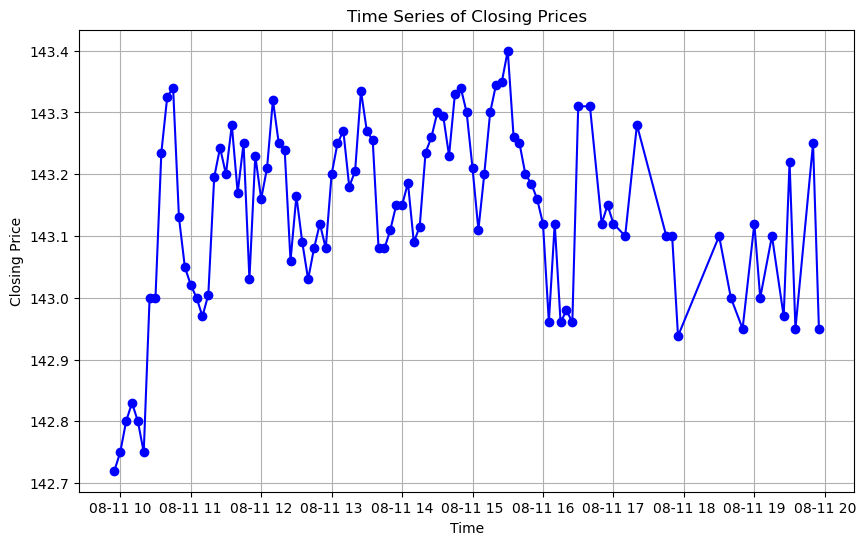

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with time series data
# Create a DataFrame from the time series dictionary
time_series_data = data.get("Time Series (5min)")
df = pd.DataFrame(time_series_data).transpose()

# Convert the index to datetime format
df.index = pd.to_datetime(df.index)

# Convert '4. close' column to float
df['4. close'] = df['4. close'].astype(float)

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['4. close'], marker='o', linestyle='-', color='b')
plt.title('Time Series of Closing Prices')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.grid()
plt.show()


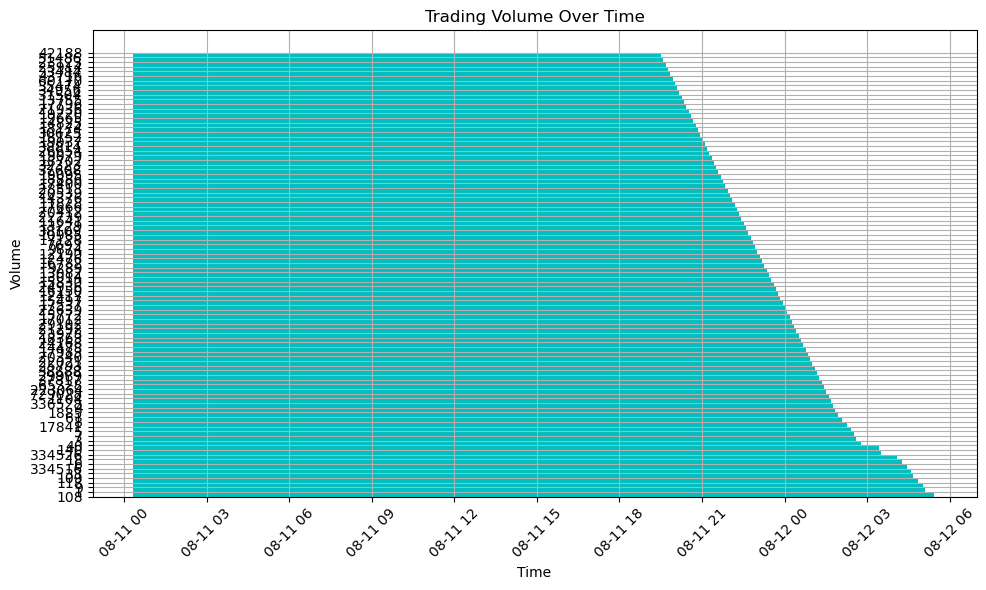

In [26]:
plt.figure(figsize=(10, 6))
plt.bar(df.index, df['5. volume'], color='c')
plt.title('Trading Volume Over Time')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


In [28]:
!pip install mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 754.9 kB/s eta 0:00:00 kB/s eta 0:00:01


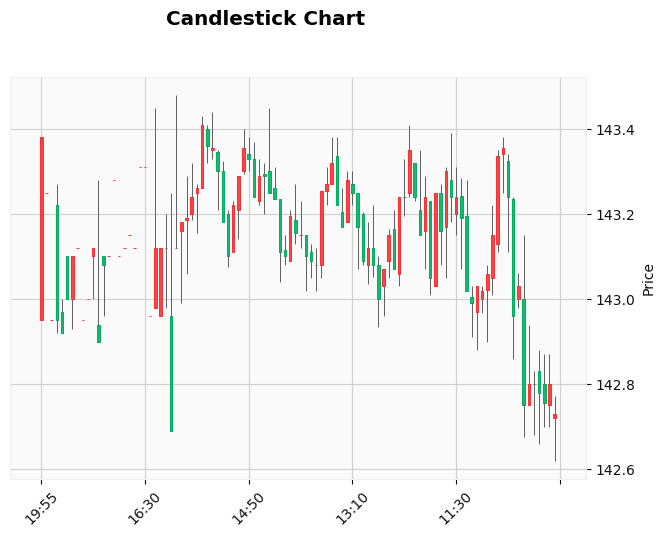

In [32]:
import mplfinance as mpf

# Prepare data for candlestick plot
candlestick_data = df[['1. open', '2. high', '3. low', '4. close']].astype(float)
candlestick_data.index = pd.to_datetime(candlestick_data.index)

# Rename the columns
candlestick_data.columns = ['Open', 'High', 'Low', 'Close']

# Plot the candlestick chart
mpf.plot(candlestick_data, type='candle', style='yahoo', title='Candlestick Chart', ylabel='Price')


In [33]:
# Assuming df is your DataFrame with the data
# Convert the index to datetime format if it's not already
df.index = pd.to_datetime(df.index)

# Specify the date for which you want to find the highest value
desired_date = '2023-08-11'  # Replace with your desired date

# Use the .loc[] indexer to filter rows with the desired date and find the highest high
high_on_desired_date = df.loc[desired_date, '2. high'].max()

print(f"The highest high on {desired_date} was: {high_on_desired_date}")


The highest high on 2023-08-11 was: 143.4800


In [12]:
from pyspark.sql import SparkSession
import json

# Initialize a Spark session
spark = SparkSession.builder.appName("HDFS_JSON_Processing").getOrCreate()

# Replace these values with your HDFS connection details
hdfs_host = 'localhost'  # Replace with your HDFS NameNode hostname or IP
hdfs_port = '9000'        # Replace with your HDFS NameNode port
hdfs_path = '/user/parquet_to_text_output/part-00000-d33b2786-a3c1-4dc6-ac13-6844bc2edacd-c000.txt'

# Construct the full HDFS URL
hdfs_file = f'hdfs://{hdfs_host}:{hdfs_port}{hdfs_path}'

# Read the HDFS file using Spark
rdd = spark.sparkContext.textFile(hdfs_file)

# Process each JSON object
for json_content in rdd.collect():
    try:
        data = json.loads(json_content)
        time_series = data.get("Time Series (5min)")
        print(time_series)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")

# Stop the Spark session
spark.stop()


{'2023-08-11 19:55:00': {'1. open': '143.3800', '2. high': '143.3800', '3. low': '142.9500', '4. close': '142.9500', '5. volume': '108'}, '2023-08-11 19:50:00': {'1. open': '143.2500', '2. high': '143.2500', '3. low': '143.2500', '4. close': '143.2500', '5. volume': '1'}, '2023-08-11 19:35:00': {'1. open': '142.9500', '2. high': '142.9500', '3. low': '142.9500', '4. close': '142.9500', '5. volume': '1'}, '2023-08-11 19:30:00': {'1. open': '142.9500', '2. high': '143.2700', '3. low': '142.9200', '4. close': '143.2200', '5. volume': '9'}, '2023-08-11 19:25:00': {'1. open': '142.9200', '2. high': '143.0000', '3. low': '142.9200', '4. close': '142.9700', '5. volume': '118'}, '2023-08-11 19:15:00': {'1. open': '143.0000', '2. high': '143.1000', '3. low': '143.0000', '4. close': '143.1000', '5. volume': '109'}, '2023-08-11 19:05:00': {'1. open': '143.1000', '2. high': '143.1000', '3. low': '142.9300', '4. close': '143.0000', '5. volume': '33'}, '2023-08-11 19:00:00': {'1. open': '143.1200', 